In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

In [5]:
import os, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack

In [6]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(dpi=100, fontsize=15)

In [7]:
TIGRESS = '/tigress/jiaxuanl/Data/HSC/LSBG'

### Johnny's completeness map for detection

In [8]:
x = np.loadtxt(f'{TIGRESS}/Catalog/Greco_completeness_S18A/completeness-x.txt')
y = np.loadtxt(f'{TIGRESS}/Catalog/Greco_completeness_S18A/completeness-y.txt')
comp_map = np.loadtxt(f'{TIGRESS}/Catalog/Greco_completeness_S18A/completeness.txt') / 100

In [537]:
from scipy.interpolate import interp2d

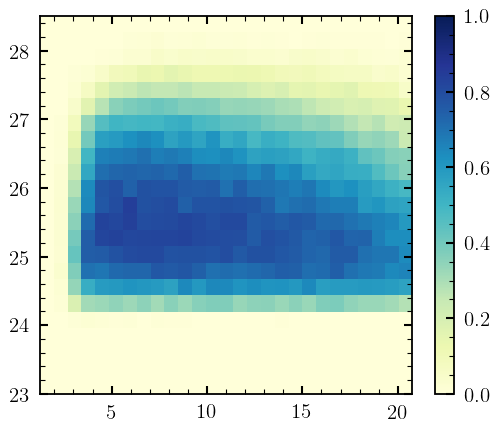

In [540]:
plt.imshow(comp_map, 
           extent=[min(x), max(x), min(y), max(y)], 
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=1)
plt.colorbar()

### Analyze mock gals

In [9]:
obj_cat = Table.read('./Catalog/mock_sample/mock_obj_cat_0_1000.fits')
old_meas_cat = Table.read('./Catalog/mock_sample/_lsbg_meas_vanillanosegmap.fits')
old_seg_meas_cat = Table.read('./Catalog/mock_sample/_lsbg_meas_vanillasegmap.fits')

# meas_cat = Table.read('./Catalog/mock_sample/_lsbg_meas_new_wavelet_nosegmap.fits')
# seg_meas_cat = Table.read('./Catalog/mock_sample/_lsbg_meas_new_wavelet_segmap.fits')
# params_cat = Table.read('./Catalog/mock_sample/mock_gal_param_truth.fits')
meas_cat = Table.read('./Catalog/mock_sample/_lsbg_mea_wavelet_nosegmap.fits')
seg_meas_cat = Table.read('./Catalog/mock_sample/_lsbg_mea_wavelet_segmap.fits')
params_cat = Table.read('./Catalog/mock_sample/mock_gal_param_truth.fits')

bad_flag = (~obj_cat['image_flag'].data).any(axis=1)
bad_flag |= np.isnan(meas_cat['rhalf_circularized'])

obj_cat = obj_cat[~bad_flag]
params_cat = params_cat[~bad_flag]
meas_cat = meas_cat[~bad_flag]
seg_meas_cat = seg_meas_cat[~bad_flag]

old_meas_cat = old_meas_cat[~bad_flag]
old_seg_meas_cat = old_seg_meas_cat[~bad_flag]

In [10]:
udg_cat = Table.read(f'{TIGRESS}/Catalog/nsa_z002_004/UDG_NSA_MW_z002_004_new.fits')

### Plot model param distribution

In [11]:
from scipy.stats import binned_statistic_2d

In [12]:
bin_num = [10, 10]
_range = [[1, 10], [24, 29]]

In [13]:
res_truth = binned_statistic_2d(
    params_cat['rhalf_circularized'].data,
    params_cat['SB_eff_g'].data,
    None,
    statistic='count',
    bins=bin_num,
    range=_range, 
    expand_binnumbers=False)

In [14]:
res_meas = binned_statistic_2d(
    meas_cat['rhalf_circularized'].data * 0.168,
    meas_cat['SB_eff_avg'].data[:, 0],
    None,
    statistic='count',
    bins=[bin_num, bin_num],
    range=_range, 
    expand_binnumbers=False)

ValueError: The smallest edge difference is numerically 0.

In [82]:
ratio_set = []
for i in range((bin_num + 2)**2):
    ratio_set.append(np.sum(np.in1d(
        params_cat[res_truth.binnumber == i]['viz-id'].data, 
        params_cat[res_meas.binnumber == i]['viz-id'].data)) / len(
        params_cat[res_truth.binnumber == i]['viz-id'].data))

TypeError: can only concatenate list (not "int") to list

In [313]:
ratio_set = np.array(ratio_set).reshape(bin_num + 2, bin_num + 2).T
ratio_set = ratio_set[1:-1, 1:-1]

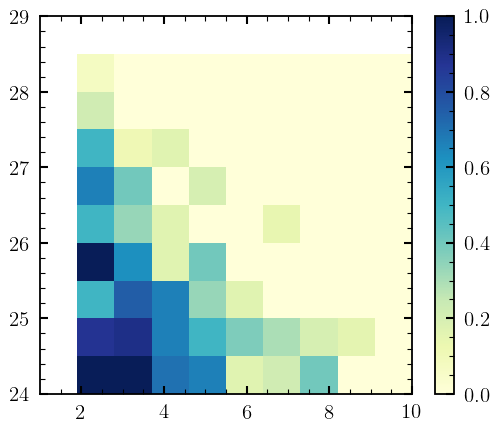

In [315]:
plt.imshow(ratio_set, 
           extent=[item for sublist in _range for item in sublist],
           vmin=0, aspect='auto', 
    cmap='YlGnBu',)
plt.colorbar()

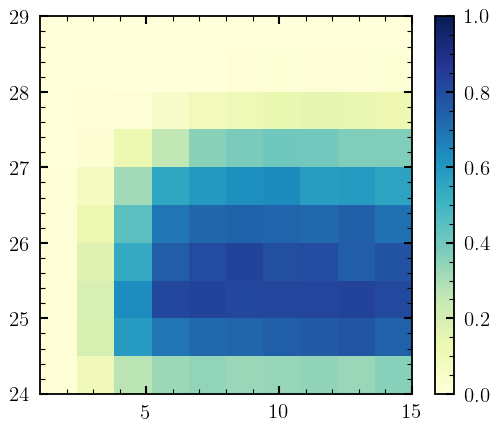

In [316]:
plt.imshow(f((res_truth.x_edge[1:] + res_truth.x_edge[:-1]) / 2, 
             (res_truth.y_edge[1:] + res_truth.y_edge[:-1]) / 2) / 100, 
           extent=[1, 15, 24, 29],
           vmin=0, vmax=1, aspect='auto', 
    cmap='YlGnBu',)
plt.colorbar()

In [317]:
mat = f((res_truth.x_edge[1:] + res_truth.x_edge[:-1]) / 2, 
             (res_truth.y_edge[1:] + res_truth.y_edge[:-1]) / 2) / 100
mat *= ratio_set

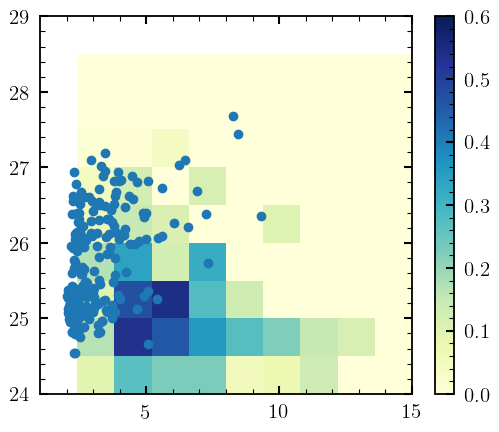

In [320]:
plt.imshow(mat,
           extent=[1, 15, 24, 29],
           vmin=0, vmax=0.6, aspect='auto', 
    cmap='YlGnBu',)
plt.colorbar()

plt.scatter(udg_cat['rhalf_circularized'].data * 0.168, 
            udg_cat['SB_eff_avg'][:, 0].data)

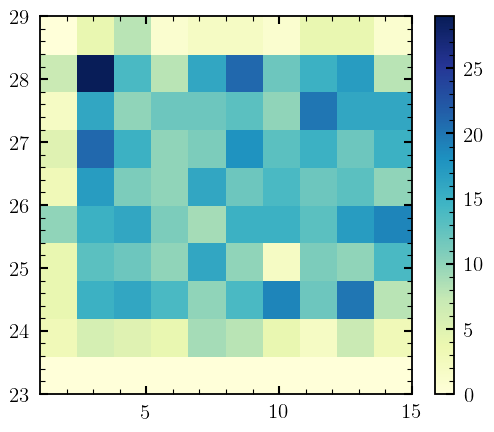

In [123]:
(h_truth, x_edges, y_edges, _) = plt.hist2d(
    params_cat['rhalf_circularized'].data,
    params_cat['SB_eff_g'].data,
    bins=[10, 10],
    range=[[1, 15], [23, 29]],
    vmin=0,
    cmap='YlGnBu',
    )
plt.colorbar()

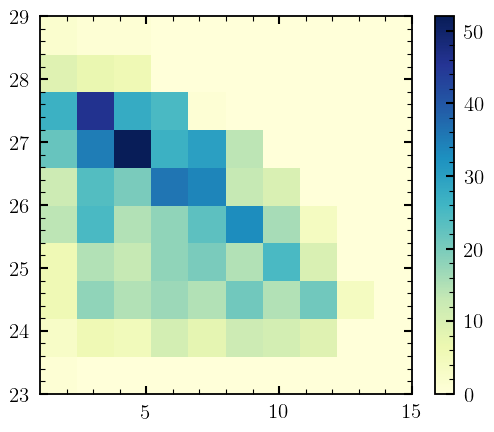

In [124]:
(h_meas, x_edges, y_edges, _) = plt.hist2d(
    meas_cat['rhalf_circularized'].data * 0.168,
    meas_cat['SB_eff_avg'].data[:, 0],
    bins=[10, 10],
    range=[[1, 15], [23, 29]],
    vmin=0,
    cmap='YlGnBu',
    )
plt.colorbar()

In [125]:
ratio = h_meas / h_truth
ratio = np.nan_to_num(ratio, 0, posinf=0)

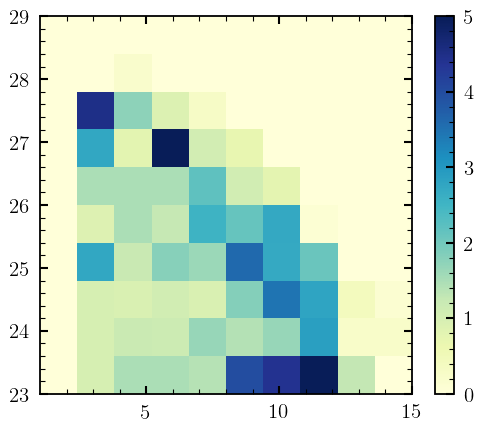

In [127]:
plt.imshow(ratio, 
           extent=[1, 15, 23, 29],
           vmin=0, vmax=5, aspect='auto', 
    cmap='YlGnBu',)
plt.colorbar()

Text(0, 0.5, '$R_e$ [measure]')

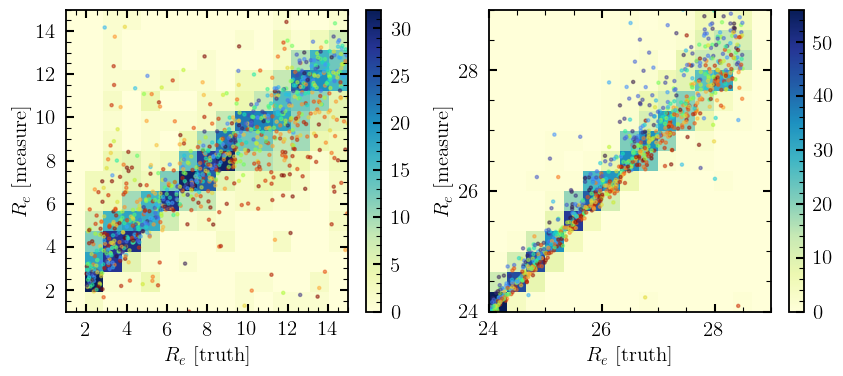

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plt.sca(axes[0])
re_meas = meas_cat['rhalf_circularized'].data * 0.168 
#* np.sqrt(1 - meas_cat['ell_sym'].data)
re_truth =  params_cat['rhalf_circularized'].data# * np.sqrt(1 - params_cat['ellip'].data)
# params_cat['rhalf_circularized'].data
SB_meas = meas_cat['SB_eff_avg'].data[:, 0]
SB_truth = params_cat['SB_eff_g'].data


(h_re, x_edges, y_edges, im) = plt.hist2d(
    re_truth, re_meas,
    bins=[15, 15],
    range=[[1, 15], [1, 15]],
    cmap='YlGnBu',
    )
plt.scatter(re_truth, re_meas, c=SB_truth, s=5, alpha=0.5)
# plt.axes().set_aspect('equal')
plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar(im)
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')


plt.sca(axes[1])
(h_re, x_edges, y_edges, im) = plt.hist2d(
    SB_truth, SB_meas,
    bins=[15, 15],
    range=[[24, 29], [24, 29]],
    cmap='YlGnBu',
    )
plt.scatter(SB_truth, SB_meas, c=re_truth, s=5, alpha=0.5)
# plt.axes().set_aspect('equal')
plt.xticks(ticks=np.arange(24, 29, 2))
plt.yticks(ticks=np.arange(24, 29, 2))
plt.colorbar(im)
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')

(24.0, 29.0)

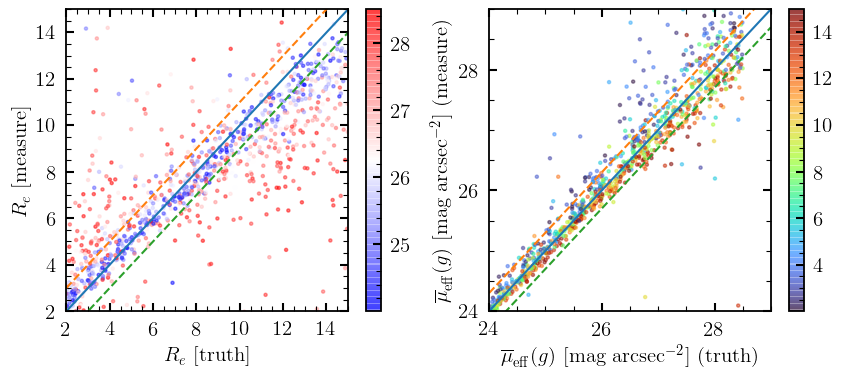

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

re_meas = meas_cat['rhalf_circularized'].data * 0.168 
#* np.sqrt(1 - meas_cat['ell_sym'].data)
re_truth =  params_cat['rhalf_circularized'].data
SB_meas = meas_cat['SB_eff_avg'].data[:, 0]
SB_truth = params_cat['SB_eff_g'].data

plt.sca(axes[0])
plt.scatter(re_truth, re_meas, c=SB_truth, 
            cmap='bwr',
            s=5, alpha=0.5)
x = np.linspace(2, 15, 10)
plt.plot(x, x)
plt.plot(x, x + 1, '--')
plt.plot(x, x - 1, '--')

plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar()
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')
plt.xlim(2, 15)
plt.ylim(2, 15)

plt.sca(axes[1])
SB_meas = meas_cat['SB_eff_avg'].data[:, 0]
SB_truth = params_cat['SB_eff_g'].data

plt.scatter(SB_truth, SB_meas, c=re_truth, s=5, alpha=0.5)
x = np.linspace(24, 29, 10)
plt.plot(x, x)
plt.plot(x, x + 0.3, '--')
plt.plot(x, x - 0.3, '--')
plt.colorbar()
plt.xticks(ticks=np.arange(24, 29, 2))
plt.yticks(ticks=np.arange(24, 29, 2))
plt.xlabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (truth)')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (measure)')

plt.xlim(24, 29)
plt.ylim(24, 29)

(2.0, 15.0)

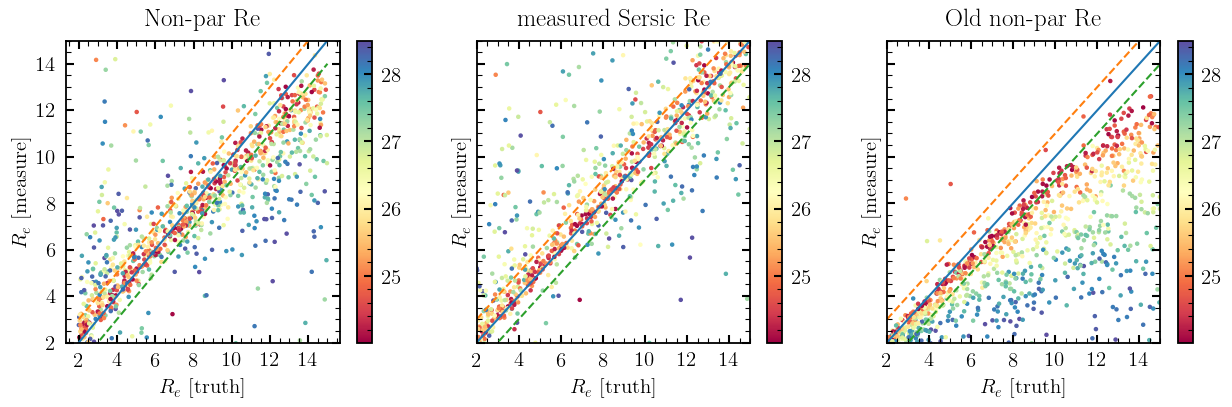

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

re_truth = params_cat['rhalf_circularized'].data
SB_truth = params_cat['SB_eff_g'].data

plt.sca(axes[0])
re_meas = meas_cat['rhalf_circularized'].data * 0.168 
plt.scatter(re_truth, re_meas, c=SB_truth, 
            cmap='Spectral',
            s=5, alpha=1)
x = np.linspace(2, 15, 10)
plt.plot(x, x)
plt.plot(x, x + 1, '--')
plt.plot(x, x - 1, '--')
plt.title('Non-par Re')
plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar()
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')
# plt.xlim(2, 15)
# plt.ylim(2, 15)

plt.sca(axes[1])
re_meas = meas_cat['sersic_rhalf'].data * 0.168 * np.sqrt(1 - seg_meas_cat['ell_sym'].data)
plt.scatter(re_truth, re_meas, c=SB_truth, 
            cmap='Spectral',
            s=5, alpha=1)
x = np.linspace(2, 15, 10)
plt.plot(x, x)
plt.plot(x, x + 1, '--')
plt.plot(x, x - 1, '--')
plt.title('measured Sersic Re')
plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar()
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')
plt.xlim(2, 15)
plt.ylim(2, 15)

plt.sca(axes[2])
re_meas = old_meas_cat['rhalf_circularized'].data * 0.168 
plt.scatter(re_truth, re_meas, c=SB_truth, 
            cmap='Spectral',
            s=5, alpha=1)
x = np.linspace(2, 15, 10)
plt.plot(x, x)
plt.plot(x, x + 1, '--')
plt.plot(x, x - 1, '--')
plt.title('Old non-par Re')
plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar()
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')
plt.xlim(2, 15)
plt.ylim(2, 15)

In [19]:
g_mag = meas_cat['mag'].data[:, 0]
r_mag = meas_cat['mag'].data[:, 1]
i_mag = meas_cat['mag'].data[:, 2]

color_bound = [0.1, 1.2]
half_width = 0.25

mask = (g_mag - i_mag < color_bound[1]) & (g_mag - i_mag > color_bound[0]) & (
    (g_mag - r_mag) > 0.7 * (g_mag - i_mag) - half_width) & (
    (g_mag - r_mag) < 0.7 * (g_mag - i_mag) + half_width) & (i_mag < 22.5)

mask &= (meas_cat['rhalf_circularized'] > 2.0 / 0.168)# & (meas_cat['rhalf_circularized'] < 12 / 0.168)

mask &= (meas_cat['SB_0'][:, 0] > 22.0)

mask &= (meas_cat['SB_eff_avg'][:, 0] > 23.0)

mask &= (meas_cat['ell_sym'] < 0.65)

# mask &= (meas_cat['M20'] < -1.1)
# mask &= (meas_cat['Gini'] < 0.7)
# mask &= ~((meas_cat['M20'] < -1.6) & (
#     meas_cat['Gini'] > meas_cat['M20'] * 0.136 + 0.788) & (meas_cat['Gini'] < meas_cat['M20'] * -0.136 + 0.33))
#mask &= (meas_cat['Gini'] < meas_cat['M20'] * -0.136 + 0.37)

mask &= (meas_cat['C'] < 3.5) & (meas_cat['C'] > 1.8)

# mask &= (seg_meas_cat['rhalf_circularized'] > 1.8 / 0.168) & (seg_meas_cat['rhalf_circularized'] < 12 / 0.168)

In [20]:
bin_num = [15, 15]
_range = [[1, 12], [24, 29]]
_extent = [item for sublist in _range for item in sublist]

In [21]:
res_truth = binned_statistic_2d(
    params_cat['rhalf_circularized'].data,
    params_cat['SB_eff_g'].data,
    None,
    statistic='count',
    bins=bin_num,
    range=_range,
    )

res_truth_cuts = binned_statistic_2d(
    params_cat['rhalf_circularized'].data[mask],
    params_cat['SB_eff_g'].data[mask],
    None,
    statistic='count',
    bins=bin_num,
    range=_range,
    )

res_meas = binned_statistic_2d(
    meas_cat['rhalf_circularized'].data * 0.168,
    meas_cat['SB_eff_avg'].data[:, 0],
    None,
    statistic='count',
    bins=bin_num,
    range=_range,
    )

res_meas_cuts = binned_statistic_2d(
    meas_cat['rhalf_circularized'].data[mask] * 0.168,
    meas_cat['SB_eff_avg'].data[:, 0][mask],
    None,
    statistic='count',
    bins=bin_num,
    range=_range,
    )

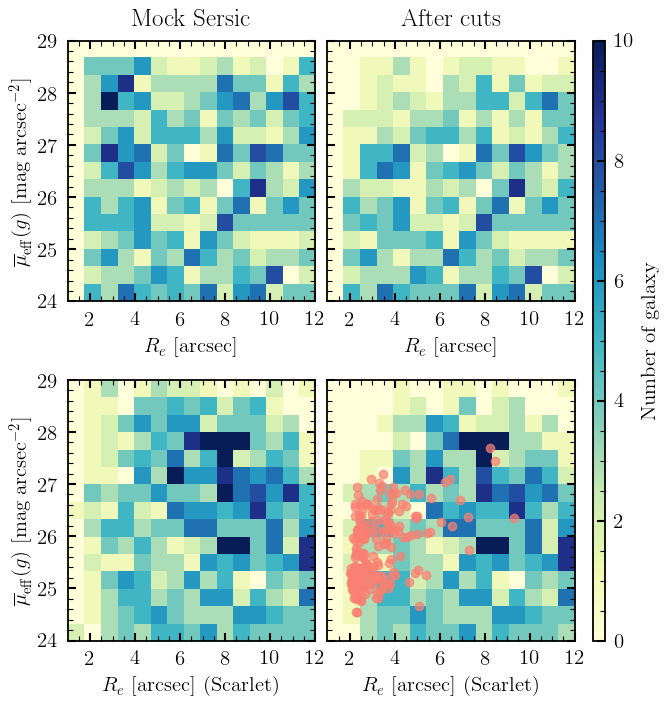

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6), sharey=True, sharex=False)

# In original size
plt.sca(axes[0, 0])
plt.imshow(res_truth.statistic.T,
           extent=_extent,
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=10)

plt.sca(axes[0, 1])
plt.imshow(res_truth_cuts.statistic.T,
           extent=_extent,
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=10)

# In measured size
plt.sca(axes[1, 0])
plt.imshow(res_meas.statistic.T,
           extent=_extent,
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=10)

plt.sca(axes[1, 1])
im = plt.imshow(res_meas_cuts.statistic.T,
           extent=_extent,
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=10)
plt.scatter(udg_cat['rhalf_circularized'].data * 0.168,
            udg_cat['SB_eff_avg'][:, 0].data, color='salmon', alpha=0.7)

for ax in axes.ravel().tolist():
    ax.set_xlim(_range[0])
    ax.set_ylim(_range[1])
    ax.set_xticks(np.arange(2, 13, 2))
    ax.set_xlabel(r'$R_e$ [arcsec]')
for ax in axes[1]:
    ax.set_xlabel(r'$R_e$ [arcsec] (Scarlet)')
for ax in axes[:, 0]:
    ax.set_ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')

axes[0, 0].set_title('Mock Sersic')
axes[0, 1].set_title('After cuts')


# # CBAR
fig.subplots_adjust(right=0.97, bottom=0, top=1)
cbar_ax = fig.add_axes([1.0, 0., 0.02, 1])
fig.colorbar(im, cax=cbar_ax, label='Number of galaxy')

plt.subplots_adjust(wspace=0.05, hspace=0.3)

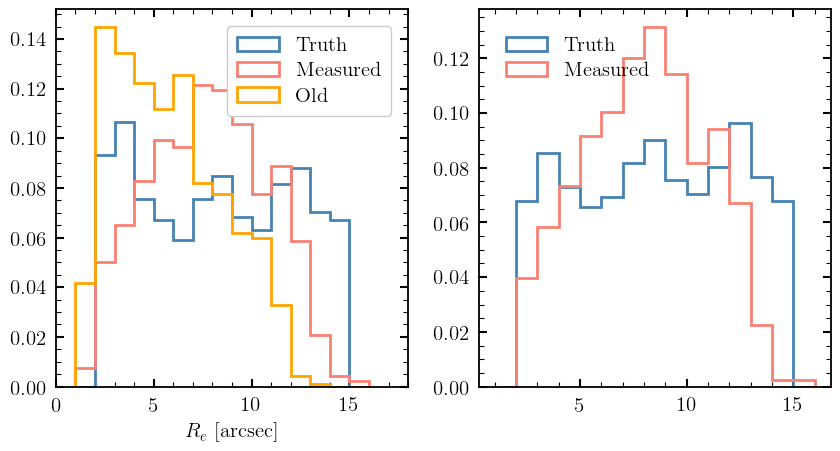

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

plt.sca(axes[0])
plt.hist(params_cat['rhalf_circularized'].data,
         range=[1, 16], bins=15,
         histtype='step', lw=2, color='steelblue', 
         label='Truth', density=True)
plt.hist(meas_cat['rhalf_circularized'].data * 0.168, 
         range=[1, 16], bins=15,
         histtype='step', lw=2, color='salmon', 
         label='Measured',density=True)
plt.hist(old_meas_cat['rhalf_circularized'].data * 0.168, 
         range=[1, 16], bins=15,
         histtype='step', lw=2, color='orange', 
         label='Old',density=True)
plt.legend(frameon=True)
plt.xlabel(r'$R_e$ [arcsec]')
plt.xlim(0, 18)

plt.sca(axes[1])
plt.hist(params_cat['rhalf_circularized'].data[mask],
         range=[1, 16], bins=15,
         histtype='step', lw=2, color='steelblue', 
         label='Truth', density=True)
plt.hist(meas_cat['rhalf_circularized'].data[mask] * 0.168, 
         range=[1, 16], bins=15,
         histtype='step', lw=2, color='salmon', 
         label='Measured',density=True)
plt.legend(loc='upper left')

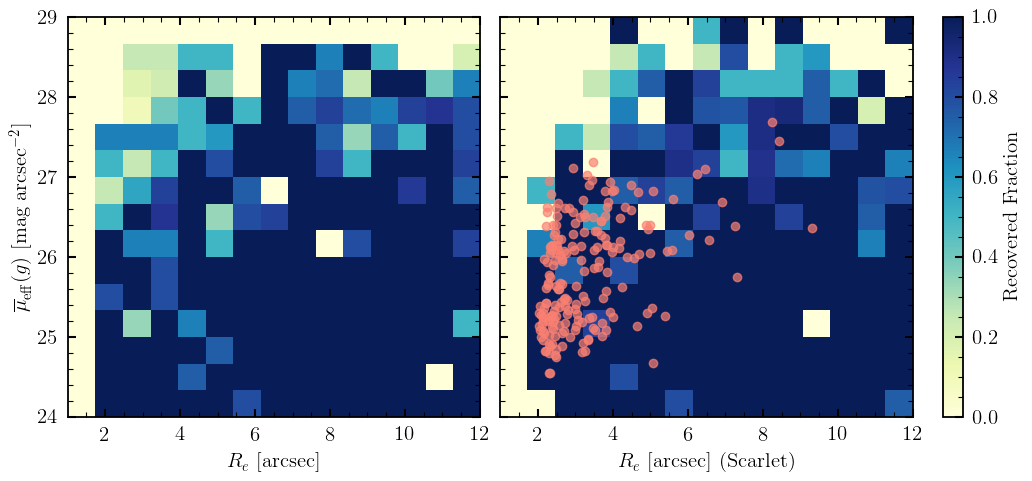

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
im = plt.imshow(np.nan_to_num(res_truth_cuts.statistic.T / res_truth.statistic.T, 0, posinf=0),
           extent=_extent,
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=1)

plt.sca(axes[1])
im = plt.imshow(np.nan_to_num(res_meas_cuts.statistic.T / res_meas.statistic.T, 0, posinf=0),
           extent=_extent,
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=1)
plt.scatter(udg_cat['rhalf_circularized'].data * 0.168,
            udg_cat['SB_eff_avg'][:, 0].data, color='salmon', alpha=0.7)


for ax in axes.ravel().tolist():
    ax.set_xlim(_range[0])
    ax.set_ylim(_range[1])
    ax.set_xticks(np.arange(2, 13, 2))

axes[0].set_xlabel(r'$R_e$ [arcsec]')
axes[0].set_ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')
axes[1].set_xlabel(r'$R_e$ [arcsec] (Scarlet)')

## CBAR
fig.subplots_adjust(right=0.97, bottom=0, top=1)
cbar_ax = fig.add_axes([1.0, 0., 0.02, 1])
fig.colorbar(im, cax=cbar_ax, label='Recovered Fraction')

plt.subplots_adjust(wspace=0.05, hspace=0.3)

In [26]:
im = plt.imshow(
    np.nan_to_num(res_meas_cuts.statistic.T / res_meas.statistic.T, 
                  0, posinf=0) * f(
        (res_truth.x_edge[1:] + res_truth.x_edge[:-1]) / 2, 
        (res_truth.y_edge[1:] + res_truth.y_edge[:-1]) / 2),
           extent=_extent,
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=1)
plt.scatter(udg_cat['rhalf_circularized'].data * 0.168,
            udg_cat['SB_eff_avg'][:, 0].data, color='salmon', alpha=0.7)

plt.colorbar(im)

NameError: name 'f' is not defined

In [30]:
re_meas_ser = (meas_cat['sersic_rhalf'] * np.sqrt(1 - seg_meas_cat['ell_sym']) * 0.168)

In [34]:
obj_cat[re_meas_ser > 20]

<Table length=41>
viz-id         ra                 dec          ... image_flag [4] psf_flag [4]
int64       float64             float64        ...      bool          bool    
------ ------------------ -------------------- ... -------------- ------------
    30  136.6152375133216    3.599789142069737 ...   True .. True True .. True
    37  354.9021760893858  -0.4412183746230317 ...   True .. True True .. True
   132  350.8793484609612   0.7003492654709937 ...   True .. True True .. True
   142 147.31631972743108 -0.02955614527762296 ...   True .. True True .. True
   148  336.6348721227499   1.1509880392524925 ...   True .. True True .. True
   155  334.2832677667005   0.9998169279829422 ...   True .. True True .. True
   163  210.5663646293533  -1.3106821544400364 ...   True .. True True .. True
   178  231.0977723062147    44.27895411534981 ...   True .. True True .. True
   201  135.7697138585649   -1.242929877038447 ...   True .. True True .. True
   204 135.61003878435443  -0.7384286884169833 ...   True .. True True .. True
   ...                ...                  ... ...            ...          ...
   767  32.39887168118219   -5.314744639731132 ...   True .. True True .. True
   789  33.58397278898382  -3.4856054144473223 ...   True .. True True .. True
   812 37.634496843389435     -4.6136878640722 ...   True .. True True .. True
   857  331.4110042979082     3.93561762956532 ...   True .. True True .. True
   866  2.185210065364207   0.9430739705686865 ...   True .. True True .. True
   876  150.9923767360023   1.8324440179479817 ...   True .. True True .. True
   911 130.29424132660634  -1.2853043954519225 ...   True .. True True .. True
   917 357.35899226978296  0.44438402944250144 ...   True .. True True .. True
   918 151.46067963329463   1.4601171564184916 ...   True .. True True .. True
   988 237.01937925419895   43.118373083932994 ...   True .. True True .. True

[<AxesSubplot:title={'center':'Background'}>,
 <AxesSubplot:title={'center':'Mock Image'}>,
 <AxesSubplot:title={'center':'Model'}>]

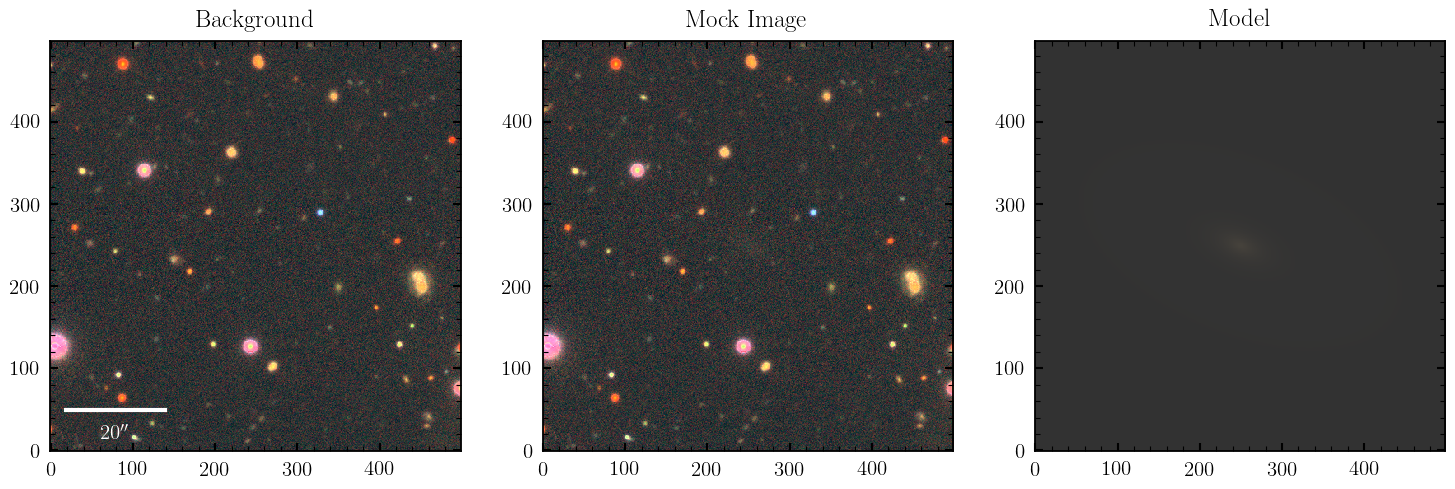

In [724]:
import pickle

with open(f'./Cutout/mock_sample/mock_{ind}.pkl', 'rb') as fp:
    gal = pickle.load(fp)
gal.display()

In [35]:
import dill
from kuaizi.measure import makeMeasurement

[<AxesSubplot:title={'center':'Data'}>,
 <AxesSubplot:title={'center':'Model'}>,
 <AxesSubplot:title={'center':'Residual'}>,
 <AxesSubplot:title={'center':'log-Likelihood'}, xlabel='Iteration'>]

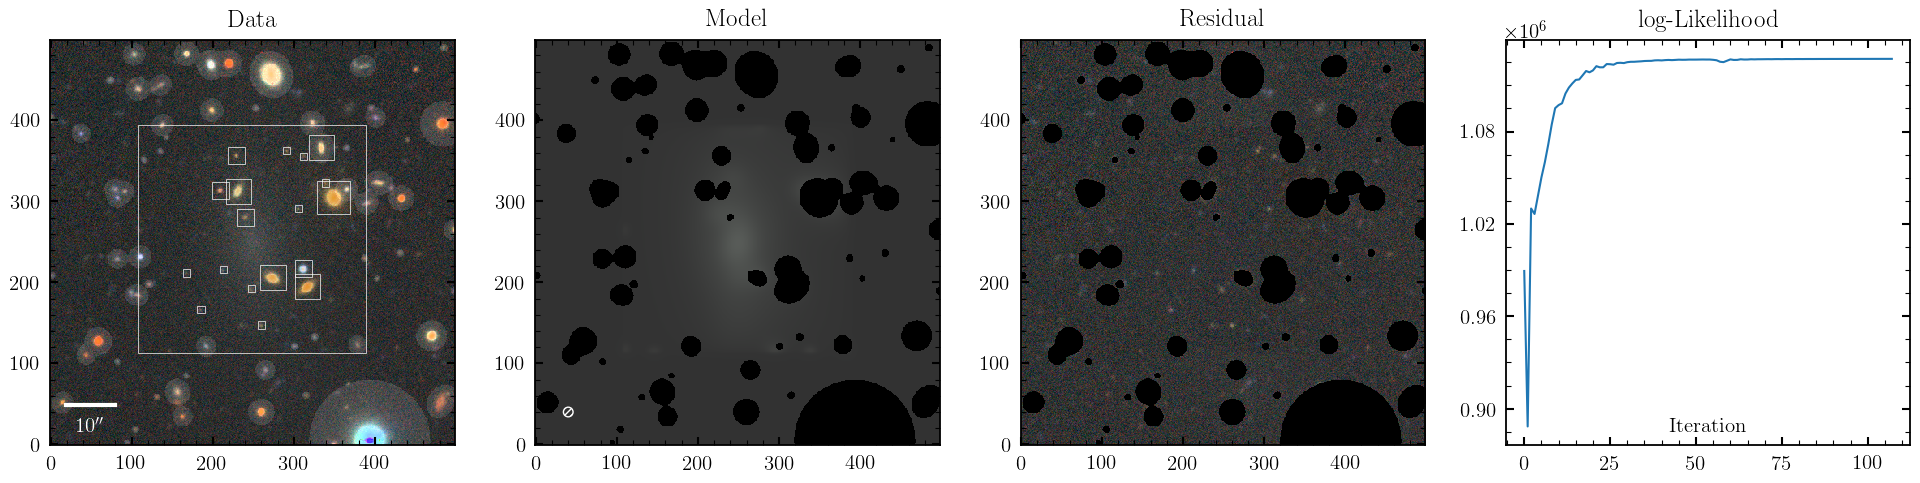

In [39]:
ind = 911
method = 'wavelet'
# method = 'vanilla'
with open(f'./Model/mock_sample/mock-{ind}-trained-model-{method}.df', "rb") as fp:
    blend, info, mask = dill.load(fp)
    fp.close()
    
kz.display.display_scarlet_results_tigress(
    blend,
    mask,
    show_ind=[0],
    #zoomin_size=50,
    minimum=-0.2,
    stretch=1,
    add_boxes=True,
    channels='griz',
    show_mask=True,
    show_mark=False, 
    show_loss=True)

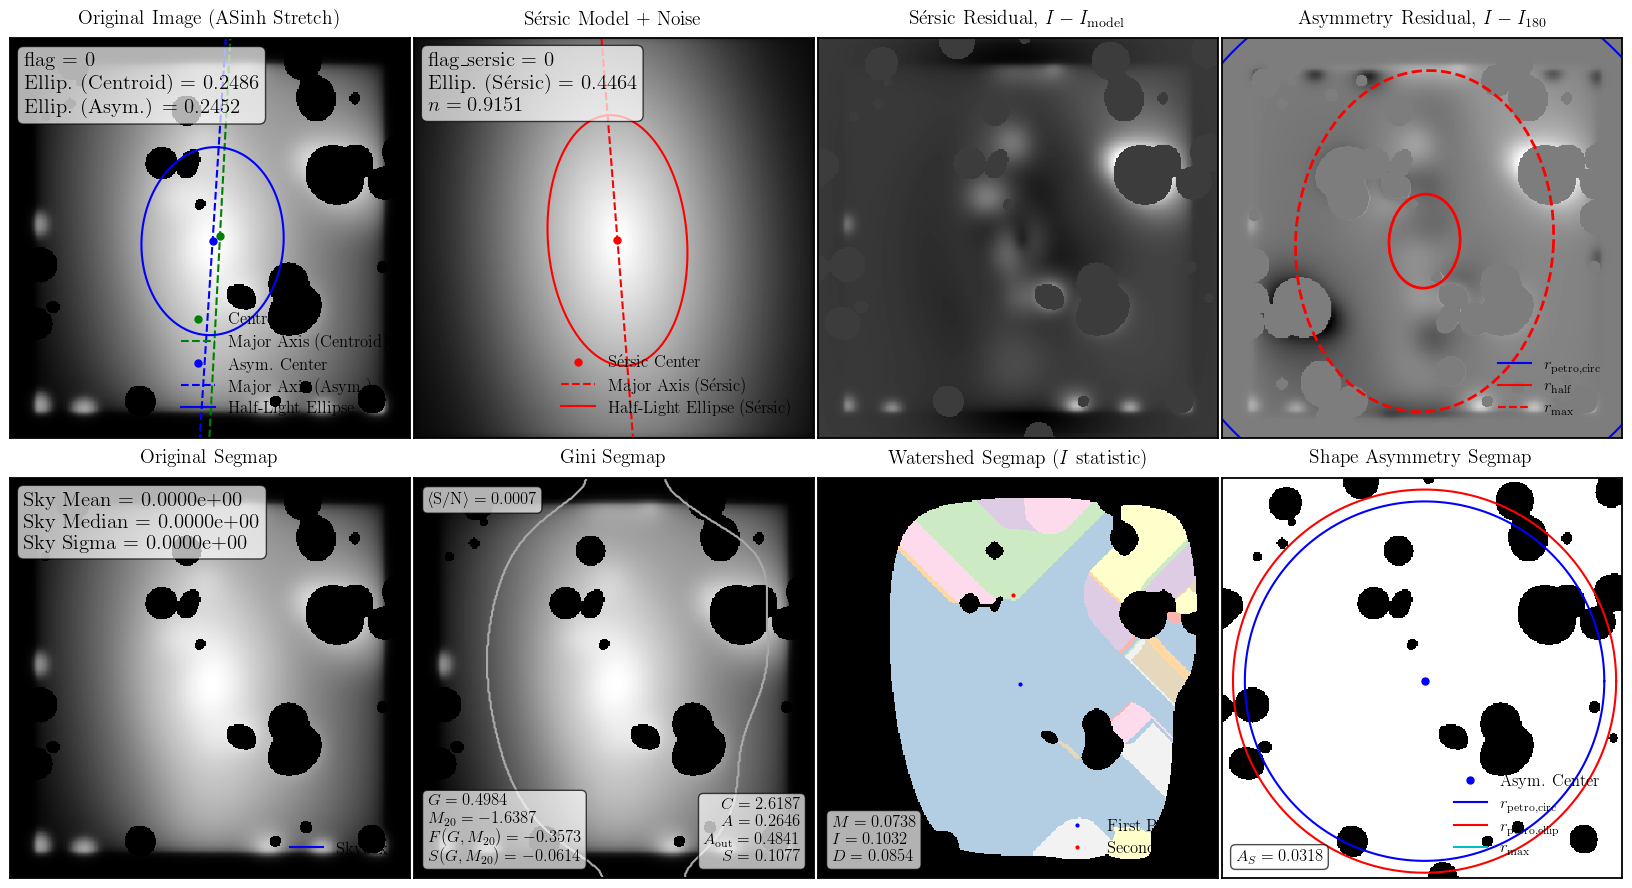

In [40]:
measurement, t = makeMeasurement(list(np.array(blend.sources)[info['sed_ind']]),
                                 blend.observations[0],
                                 aggr_mask=mask.astype(bool),
                                 makesegmap=False, sigma=0.2,
                                 zeropoint=27.0, out_prefix=None,
                                 show_fig=True, asinh_a=0.02, framealpha=0.7)
#row = _write_to_row(row, measurement)

In [41]:
print(measurement['rhalf_circularized'] * 0.168, params_cat[
    params_cat['viz-id'] == ind]['rhalf_circularized'][0])
measurement['sersic_rhalf'] * 0.168 * np.sqrt(1 - measurement['ellipticity_asymmetry'])

11.090356110772003 12.341631926323371


14.798403834063894

In [73]:
measurement['SB_eff_avg'][0], params_cat[params_cat['viz-id'] == ind]['SB_eff_g'][0]

(25.4518, 25.720428534141778)

[<AxesSubplot:title={'center':'Data'}>,
 <AxesSubplot:title={'center':'Model'}>,
 <AxesSubplot:title={'center':'Residual'}>,
 <AxesSubplot:title={'center':'log-Likelihood'}, xlabel='Iteration'>]

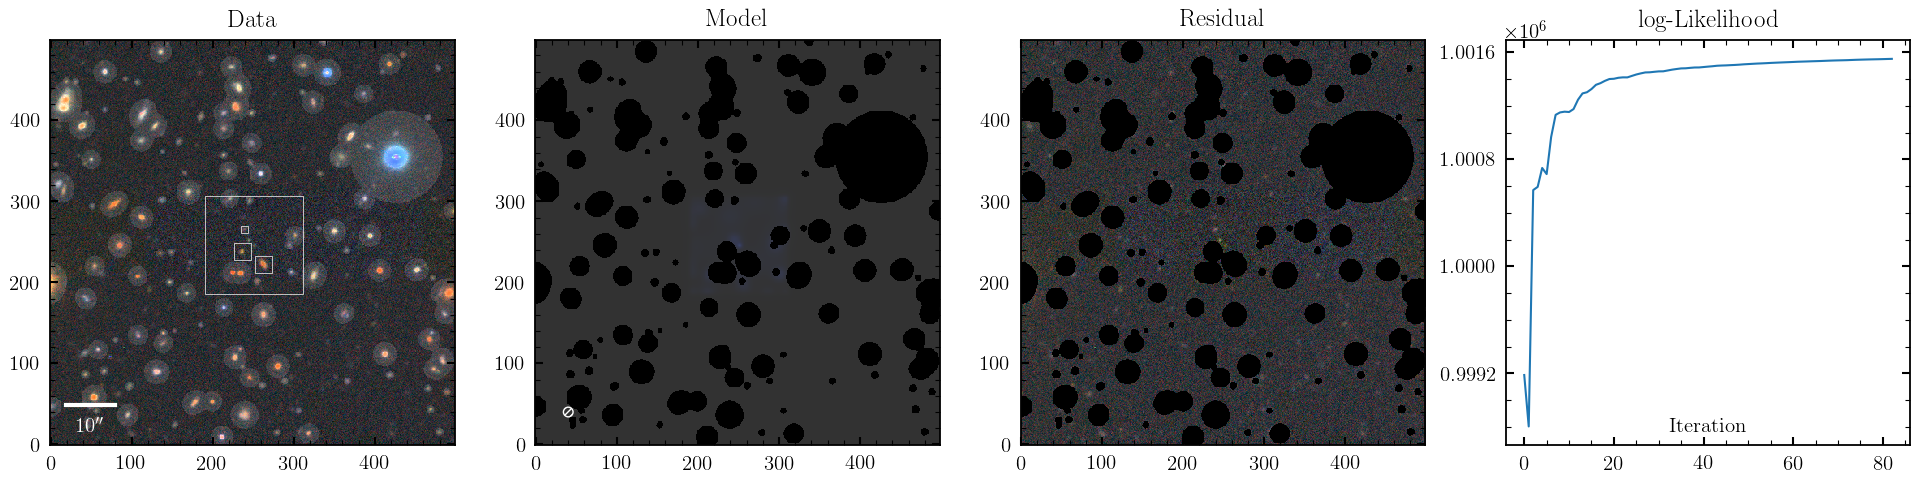

In [48]:
ind = 40
method = 'wavelet'
# method = 'vanilla'
with open(f'./Model/nsa_z002_004/nsa-{ind}-trained-model-{method}.df', "rb") as fp:
    blend, info, mask = dill.load(fp)
    fp.close()
    
kz.display.display_scarlet_results_tigress(
    blend,
    mask,
    show_ind=[0],
    #zoomin_size=50,
    minimum=-0.2,
    stretch=1,
    add_boxes=True,
    channels='griz',
    show_mask=True,
    show_mark=False, 
    show_loss=True)